# Creating Machine Learning Predictive Models for the Credit Card dataset. 

The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset contains transactions that happened in two days, where we have 492 frauds out of 284,807 transactions. It contains only numerical input variables which are the result of a PCA transformation. Due to confidentiality issues, there are not provided the original features and more background information about the data.


My approach to building the classifier is discussed in the following steps:

1. Perform Exploratory Data Analysis (EDA) on our dataset. This was completed in the last project and is avaiable on my Github page. 
2. Apply different Machine Learning algorithms to our dataset. This will be completed in this project. 
3. Train and Evaluate our models on the dataset and pick the best one. This will be completed in this project. 

# Load the Libraries

In [2]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


import gc
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn import svm
import xgboost as xgb

pd.set_option('display.max_columns', 100)


RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier


#TRAIN/VALIDATION/TEST SPLIT
#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split
TEST_SIZE = 0.20 # test size using_train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation



RANDOM_STATE = 2018

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop 
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result

IS_LOCAL = False

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Load the data

In [4]:
data_df = pd.read_csv("/Users/courtneydavid/Documents/Data Science Springboard Career Track Course/Capstone 2/creditcard.csv")

In [5]:
data_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Defining predictors and target variables

The target is the Class vraiable and the predictors are all the other variables as mentioned below. 

In [9]:
target = 'Class'
predictors = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
       'Amount']

# Splitting the Data

The data will be split into training, validation and testing sets. 

In [12]:
train_df, test_df = train_test_split(data_df, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )
train_df, valid_df = train_test_split(train_df, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

# The Class Imblance issue with the data

The class imbalance problem can be solved by various techniques.

Oversample the smaller class is one of the ways to address the imbalanced datasets. The easiest solution entails doubling examples in the smaller class, even though these examples add no new data to the model.

Using a confussion matrix is difficult to represent results of unbalanced data, we would need a different matrix to minimize both Type 1 and Type 2 errors and at the same time accounts for selectivity and specificity. 


Null Hypothesis (H0) - The transaction is not a fraud.
Alternative Hypothesis (H1) - The transaction is a fraud.

Type I error - You reject the null hypothesis when the null hypothesis is actually true.
Type II error - You fail to reject the null hypothesis when the the alternative hypothesis is true.

Cost of Type I error - You erroneously presume that the the transaction is a fraud, and a true transaction is rejected.
Cost of Type II error - You erroneously presume that the transaction is not a fraud and a ffraudulent transaction is accepted.


# Decision Tree Classifier

In [13]:
clf = DecisionTreeClassifier()

In [14]:
clf.fit(train_df[predictors], train_df[target].values)

DecisionTreeClassifier()

In [15]:
preds = clf.predict(valid_df[predictors])

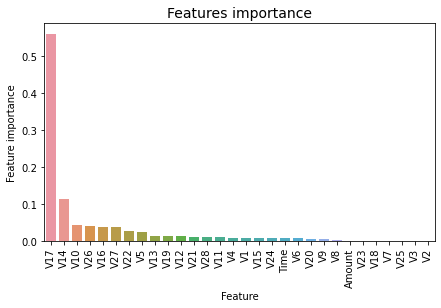

In [16]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show() 

In this model, V17 and V14 seem to be the most important features. 

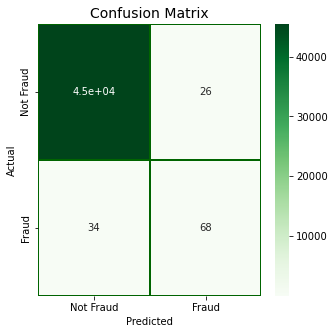

In [19]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkgreen", cmap="Greens")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [20]:
roc_auc_score(valid_df[target].values, preds)

0.8330474116758674

# Random Forest Classifier

Let's run a model using the training set for training. Then, we will use the validation set for validation.

We will use as validation criterion GINI, which formula is GINI = 2 * (AUC) - 1, where AUC is the Receiver Operating Characteristic - Area Under Curve (ROC-AUC). Number of estimators is set to 100 and number of parallel jobs is set to 4.

In [21]:
clf = RandomForestClassifier(n_jobs=NO_JOBS, 
                             random_state=RANDOM_STATE,
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)

RandonForestClassifier using the train_df data and fit function.

In [22]:
clf.fit(train_df[predictors], train_df[target].values)

RandomForestClassifier(n_jobs=4, random_state=2018, verbose=False)

Predicting the target values for the valid_df data, using predict function. 

In [23]:
preds = clf.predict(valid_df[predictors])

# Visualise feature importance

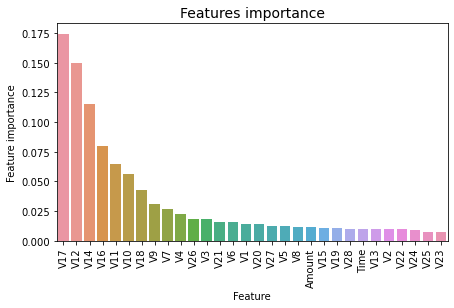

In [24]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show() 

From the above plot, it is clear that the most important features are V17, V12, V14, V10, V11, V16.

# Using a Confusion Matrix

A confusion matrix is used to measure the performance of machine learning classifc=ications. It is a tabel with four different combinations of predicted and actual values. 

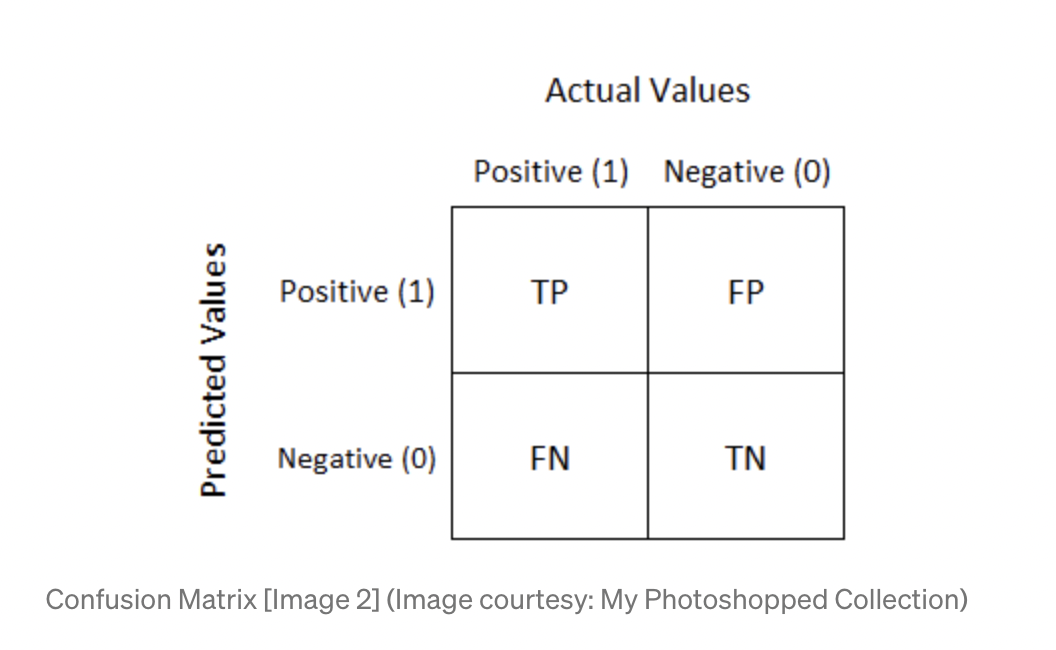

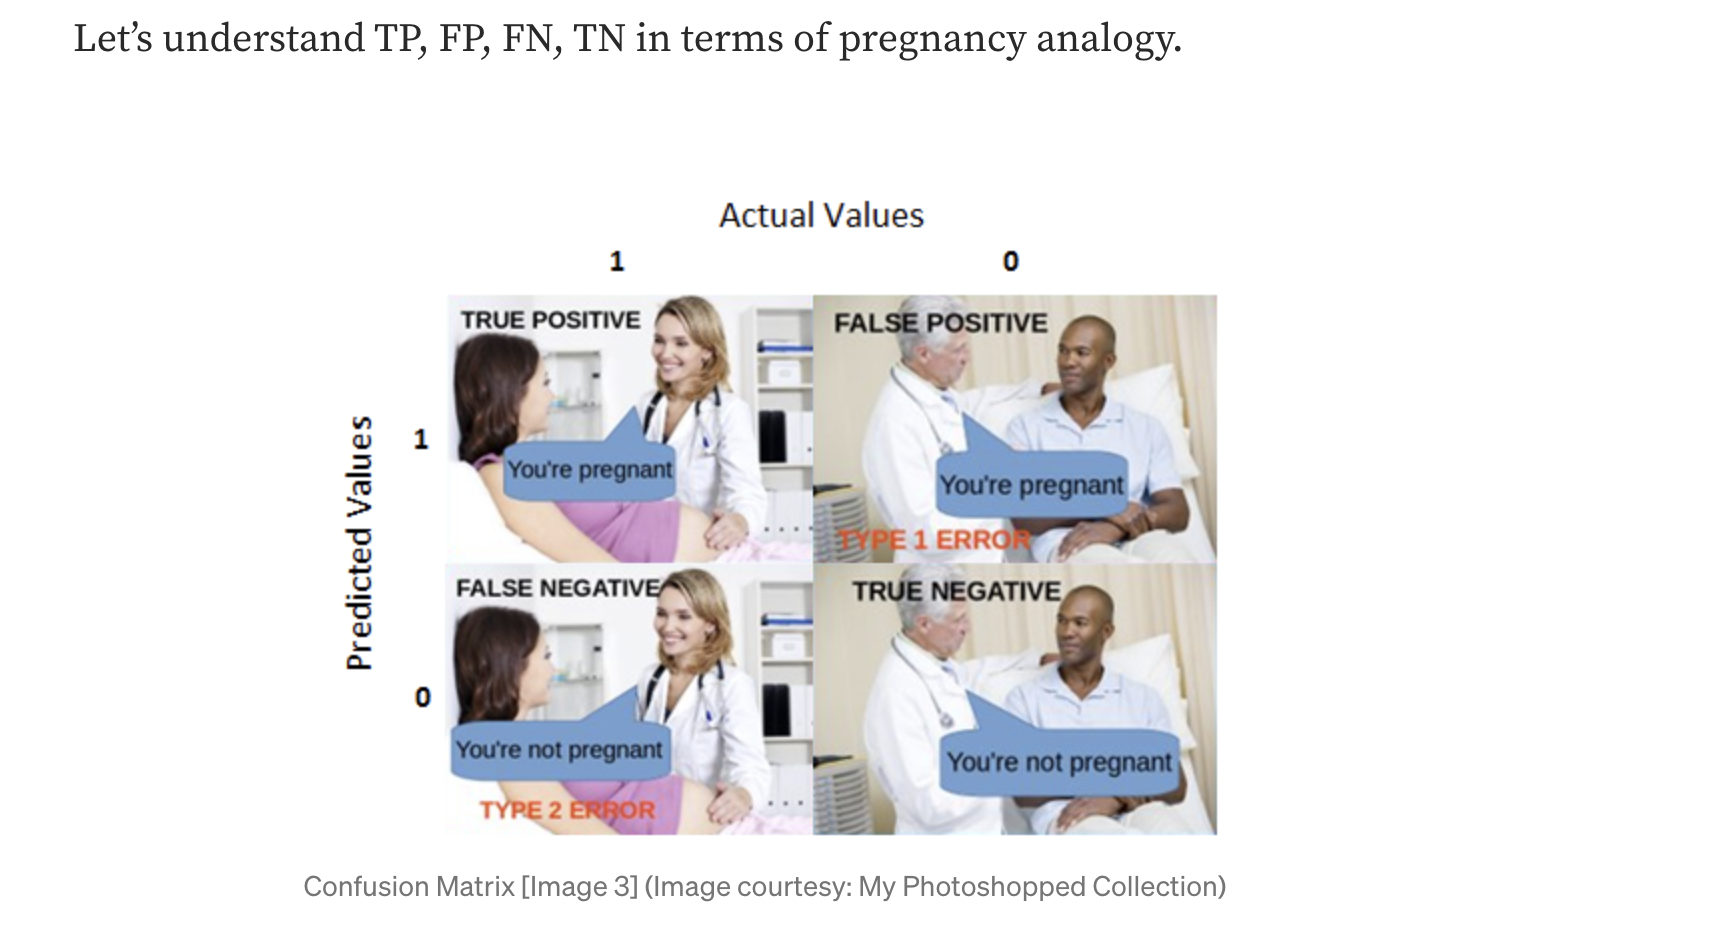

Confusion Matrix are extremely useful for measuring Recall, Precision, Specificity, Accuracy and AUC-ROC curves. 

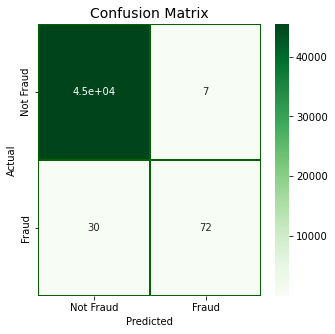

In [25]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkgreen", cmap="Greens")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

# Calculating ROC-AUC score: Area under the curve. 

In [26]:
roc_auc_score(valid_df[target].values, preds)

0.8528641975628091

# AdaBoostClassifier

In [27]:
clf = AdaBoostClassifier(random_state=RANDOM_STATE,
                         algorithm='SAMME.R',
                         learning_rate=0.8,
                             n_estimators=NUM_ESTIMATORS)

In [28]:
clf.fit(train_df[predictors], train_df[target].values)

AdaBoostClassifier(learning_rate=0.8, n_estimators=100, random_state=2018)

In [29]:
preds = clf.predict(valid_df[predictors])

# Feature Importance

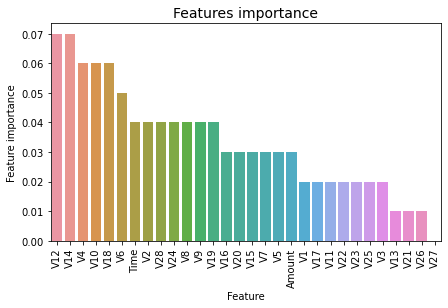

In [30]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show() 

# Confusion Matrix

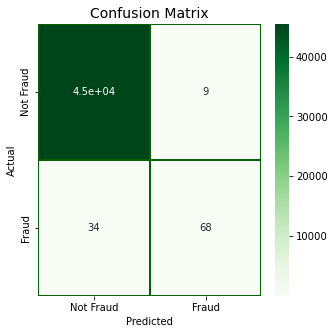

In [31]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="DarkGreen", cmap="Greens")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

# Calculating ROC-AUC score: Area under the curve. 

In [32]:
roc_auc_score(valid_df[target].values, preds)

0.8332343604519027

# CatBoost Classifier

In [33]:
clf = CatBoostClassifier(iterations=500,
                             learning_rate=0.02,
                             depth=12,
                             eval_metric='AUC',
                             random_seed = RANDOM_STATE,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = VERBOSE_EVAL,
                             od_wait=100)

In [34]:
clf.fit(train_df[predictors], train_df[target].values,verbose=True)

0:	total: 169ms	remaining: 1m 24s
50:	total: 5.12s	remaining: 45.1s
100:	total: 9.87s	remaining: 39s
150:	total: 14.5s	remaining: 33.6s
200:	total: 19.2s	remaining: 28.5s
250:	total: 23.9s	remaining: 23.7s
300:	total: 28.5s	remaining: 18.9s
350:	total: 33.1s	remaining: 14.1s
400:	total: 37.8s	remaining: 9.33s
450:	total: 42.5s	remaining: 4.61s
499:	total: 47s	remaining: 0us


In [35]:
preds = clf.predict(valid_df[predictors])

# Feature Importance

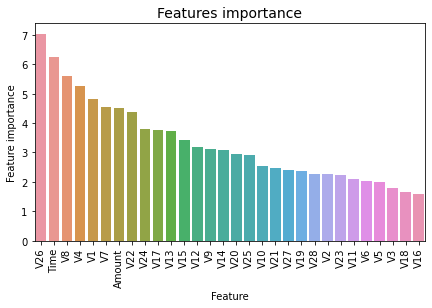

In [36]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()  

In this model, it seems that V26, Time , V8 and V4 are the most important features. 

# Confusion Matrix

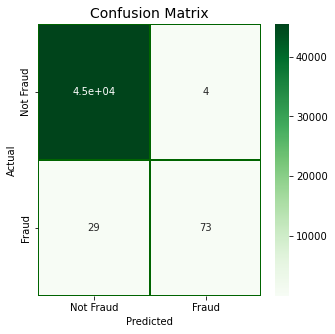

In [37]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkgreen", cmap="Greens")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

# Calculating ROC-AUC score: Area under the curve. 

In [38]:
roc_auc_score(valid_df[target].values, preds)

0.8577991493075996

# XGBoost

In [39]:
# Prepare the train and valid datasets
dtrain = xgb.DMatrix(train_df[predictors], train_df[target].values)
dvalid = xgb.DMatrix(valid_df[predictors], valid_df[target].values)
dtest = xgb.DMatrix(test_df[predictors], test_df[target].values)

#What to monitor (in this case, **train** and **valid**)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Set xgboost parameters
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.039
params['silent'] = True
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'auc'
params['random_state'] = RANDOM_STATE

In [40]:
model = xgb.train(params, 
                dtrain, 
                MAX_ROUNDS, 
                watchlist, 
                early_stopping_rounds=EARLY_STOP, 
                maximize=True, 
                verbose_eval=VERBOSE_EVAL)

[16:02:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	train-auc:0.89296	valid-auc:0.85272
[50]	train-auc:0.93946	valid-auc:0.88200
[100]	train-auc:0.94409	valid-auc:0.89079
[150]	train-auc:0.97695	valid-auc:0.96336
[200]	train-auc:0.98919	valid-auc:0.98304
[250]	train-auc:0.99382	valid-auc:0.98509
[300]	train-auc:0.99570	valid-auc:0.98582
[331]	train-auc:0.99696	valid-auc:0.98520


# Plot Variable importance

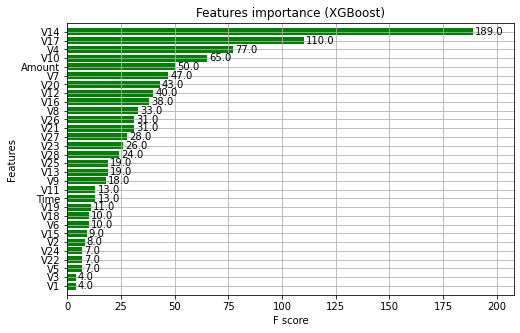

In [41]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
xgb.plot_importance(model, height=0.8, title="Features importance (XGBoost)", ax=ax, color="green") 
plt.show()

To this model, the most important features seem to be V14, V17, V4 and V10. 

In [42]:
preds = model.predict(dtest)

In [43]:
roc_auc_score(test_df[target].values, preds)

0.978161865569273

# Conclusion

In this machine learning project, I built a classifier using multiple models to detect credit crad fraud transactions. I investigated the data and dealt with the class imbalanced data. The data was split into 3 parts: a train set, test set and validation set. 

The following predictions were made through the models used in this project: 
1. Descision Tree Classifier, an AUC score of 0.83 when predicting the target for ther test set.
2. RandomForrestClassifier, an AUC scode of 0.85 when predicting the target for the test set.
3. AdaBoostClassifier model, with AUC score (0.83) for prediction of the test set target values.
4. CatBoostClassifier, with the AUC score after training 500 iterations 0.86.
5. XGBoost model , I used the validation set for the validation of the training model. The validation score was 0.985. To predict the target value, I used the model with the best training step and the AUC Score was 0.978. 

From all the mdoels used, it is clear that the XGBoost model has the best results. 



